# Tensorflow with Logistic Regression

The main agenda for this analysis is to predict credit crad fraud in the trasaction data.I will be using tensorflow to build the predictive model. To learn more about dataset,visit: https://www.kaggle.com/dalpozz/creditcardfraud.

In [155]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import matplotlib.gridspec as gridspec
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [156]:
df = pd.read_csv('creditcard.csv')



# Exploring the data

In [157]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [158]:
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

No missing value, that makes things a bit easier

After alot of heeding and trying different differential graphs for analyzing dataset, i took a step up to create statistical graphs using 'seaborn' module. 

In [159]:
#Select only the anonymized features.
v_features = df.ix[:,1:29].columns

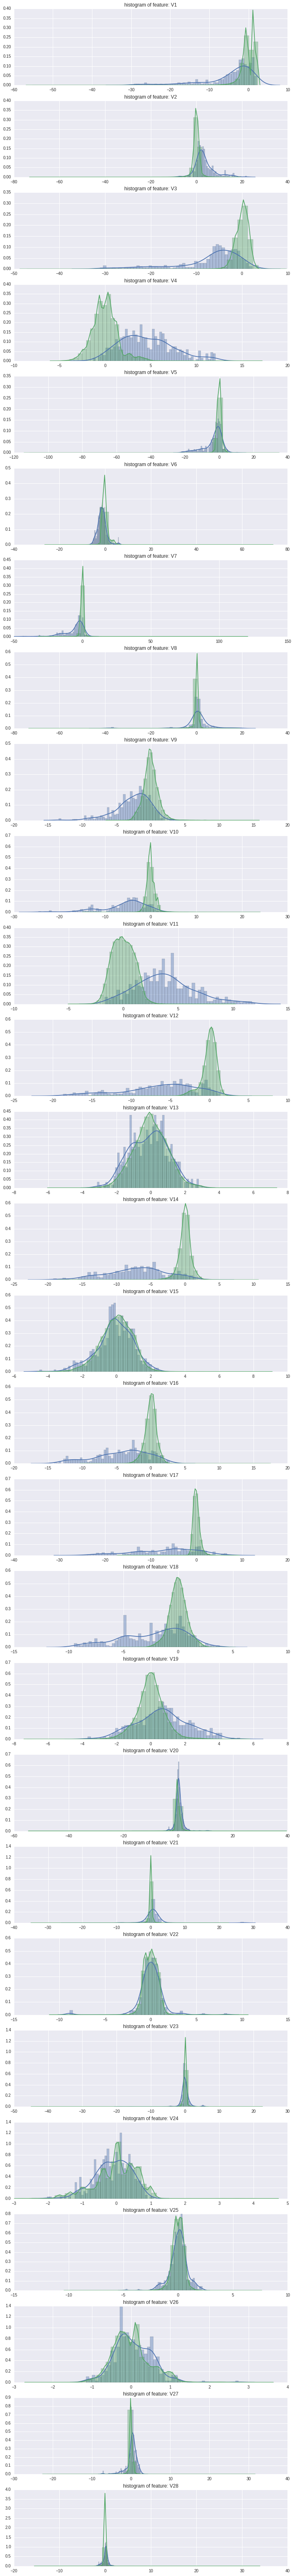

In [160]:
plt.figure(figsize=(12,28*4))
gs = gridspec.GridSpec(28, 1)
for i, cn in enumerate(df[v_features]):
    ax = plt.subplot(gs[i])
    sns.distplot(df[cn][df.Class == 1], bins=50)
    sns.distplot(df[cn][df.Class == 0], bins=50)
    ax.set_xlabel('')
    ax.set_title('histogram of feature: ' + str(cn))
plt.show() 

In [161]:
#Drop all of the features that have very similar distributions between the two types of transactions.
df = df.drop(['V28','V27','V26','V25','V24','V23','V22','V20','V15','V13','V8'], axis =1)

In [162]:
# create new fearures for distribution
df.loc[df.Class == 0, 'Normal'] = 1
df.loc[df.Class == 1, 'Normal'] = 0

In [163]:
#Rename 'Class' to 'Fraud'.
df = df.rename(columns={'Class': 'Fraud'})

In [164]:
#create Fraud and normal feature distribution
Fraud = df[df.Fraud == 1]
Normal = df[df.Normal == 1]

In [165]:
# create X_train by taking 80% of fraud transactions and 80% of normal transactions
X_train = Fraud.sample(frac=0.8)
count_Frauds = len(X_train)
X_train = pd.concat([X_train, Normal.sample(frac = 0.8)], axis = 0)
X_test = df.loc[~df.index.isin(X_train.index)]

In [166]:
# create Y_train by taking 80% of fraud transactions and 80% of normal transactions
y_train = X_train.Fraud
y_train = pd.concat([y_train, X_train.Normal], axis=1)
y_test = X_test.Fraud
y_test = pd.concat([y_test, X_test.Normal], axis=1)

In [167]:
# drop the guest features
X_train = X_train.drop(['Fraud','Normal'], axis = 1)
X_test = X_test.drop(['Fraud','Normal'], axis = 1)

In [168]:
# scale values of features
features = X_train.columns.values
for feature in features:
    mean, std = df[feature].mean(), df[feature].std()
    X_train.loc[:, feature] = (X_train[feature] - mean) / std
    X_test.loc[:, feature] = (X_test[feature] - mean) / std


# Train the graph

In [169]:
#split the dataset for train,test & validation
split = int(len(y_test)/2)

inputX = X_train.as_matrix()
print inputX.shape
inputY = y_train.as_matrix()
inputX_valid = X_test.as_matrix()[:split]
inputY_valid = y_test.as_matrix()[:split]
inputX_test = X_test.as_matrix()[split:]
inputY_test = y_test.as_matrix()[split:]

(227846, 19)


In [170]:
#parameters
learning_rate = 0.005
training_epoch = 10
batch_size = 2048
display_step = 1

In [171]:
#tf graph input
x = tf.placeholder(tf.float32,[None,19])
y = tf.placeholder(tf.float32,[None,2])

In [172]:
#set model weights
w = tf.Variable(tf.zeros([19,2]))
b = tf.Variable(tf.zeros([2]))

In [173]:
#construct model using softmax activation
pred = tf.nn.softmax(tf.matmul(x,w) + b) 

In [174]:
#minimize error using cross entropy
cost = tf.reduce_mean(-tf.reduce_sum(y*tf.log(pred)))

In [175]:
#Gradient descent
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

In [176]:
#initializing variables
init = tf.global_variables_initializer()

In [177]:
#launch the graph
with tf.Session() as sess:
    sess.run(init)
    final_output_array = []
    #training cycle
    for epoch in range(training_epoch):
        total_batch = len(inputX)/batch_size
        avg_cost = 0
        #loop over all the batches
        for batch in range(total_batch):
            batch_xs = inputX[(batch)*batch_size:(batch+1) *batch_size]
            batch_ys = inputY[(batch)*batch_size:(batch+1) *batch_size]

            # run optimizer and cost operation
            _,c= sess.run([optimizer,cost],feed_dict={x:batch_xs,y:batch_ys})
            avg_cost += c/total_batch

        correct_prediction = tf.equal(tf.argmax(pred,1),tf.argmax(y,1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction,tf.float32))

        #disply log per epoch step
        if (epoch+1) % display_step == 0:
            train_accuracy, newCost = sess.run([accuracy, cost], feed_dict={x: inputX_test,y: inputY_test})
            print "epoch:",epoch+1,"train_accuracy",train_accuracy,"cost",newCost,"valid_accuracy",sess.run([accuracy],feed_dict={x:inputX_valid,y:inputY_valid})
            print

    print 'optimization finished.'


epoch: 1 train_accuracy 0.999403 cost 8988.63 valid_accuracy [0.9991222]

epoch: 2 train_accuracy 0.999403 cost 4794.37 valid_accuracy [0.9991222]

epoch: 3 train_accuracy 0.999403 cost 2966.36 valid_accuracy [0.9991222]

epoch: 4 train_accuracy 0.999368 cost 2031.88 valid_accuracy [0.99915731]

epoch: 5 train_accuracy 0.999157 cost 1494.2 valid_accuracy [0.99894661]

epoch: 6 train_accuracy 0.999368 cost 1154.65 valid_accuracy [0.99870086]

epoch: 7 train_accuracy 0.999368 cost 925.368 valid_accuracy [0.99870086]

epoch: 8 train_accuracy 0.999368 cost 763.185 valid_accuracy [0.99870086]

epoch: 9 train_accuracy 0.999368 cost 643.631 valid_accuracy [0.99870086]

epoch: 10 train_accuracy 0.999368 cost 552.875 valid_accuracy [0.99873596]

optimization finished.
